/var/folders/gx/4gwwyrv10n9f3d2zmm71n9pm0000gq/T/ipykernel_96995/1721925838.py:43: RuntimeWarning: divide by zero encountered in log10
  snr_db = 20 * np.log10(snr)


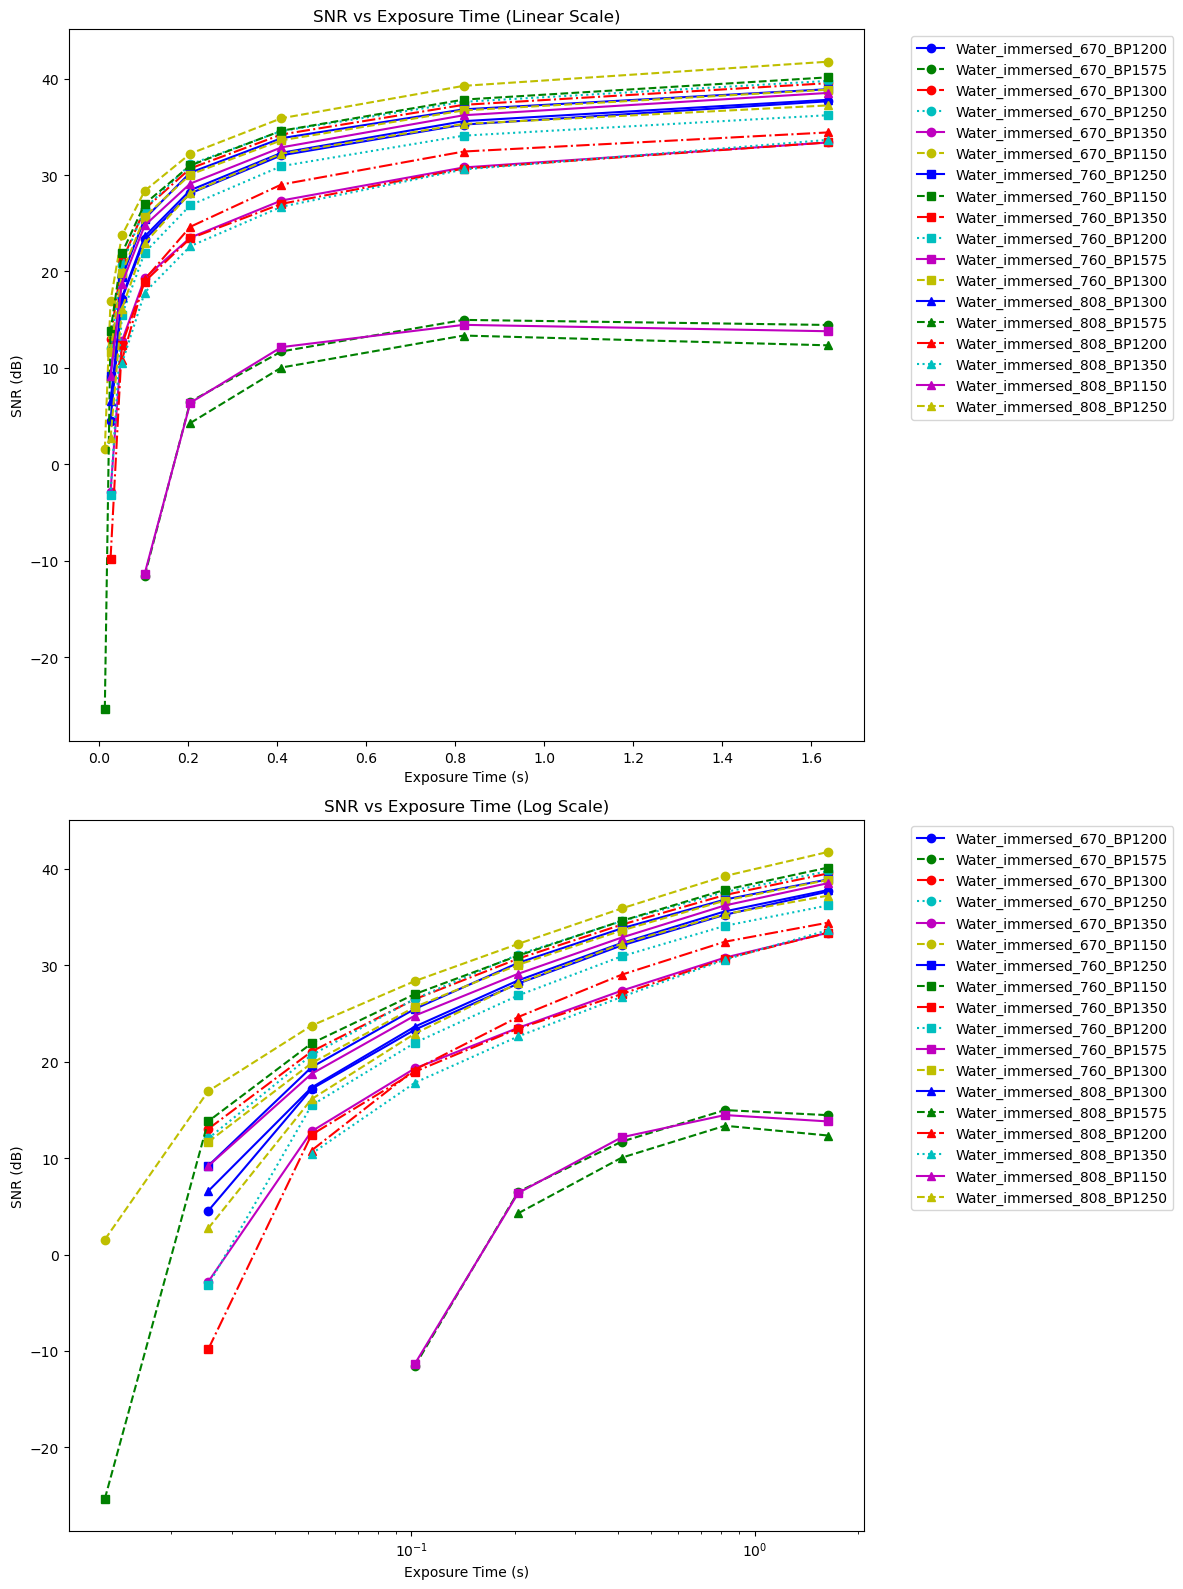

Water_immersed_670_BP1200: Saturation starts at exposure time = 1.638400 s
Water_immersed_760_BP1250: Saturation starts at exposure time = 1.638400 s
Water_immersed_808_BP1300: Saturation starts at exposure time = 1.638400 s
Water_immersed_670_BP1575: Saturation starts at exposure time = 1.638400 s
Water_immersed_670_BP1300: Saturation starts at exposure time = 1.638400 s
Water_immersed_808_BP1575: Saturation starts at exposure time = 1.638400 s
Water_immersed_760_BP1150: Saturation starts at exposure time = 1.638400 s
Water_immersed_760_BP1350: Saturation starts at exposure time = 1.638400 s
Water_immersed_808_BP1200: Saturation starts at exposure time = 1.638400 s
Water_immersed_760_BP1200: Saturation starts at exposure time = 1.638400 s
Water_immersed_808_BP1350: Saturation starts at exposure time = 1.638400 s
Water_immersed_808_BP1150: Saturation starts at exposure time = 1.638400 s
Water_immersed_760_BP1575: Saturation starts at exposure time = 1.638400 s
Water_immersed_670_BP1250

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

def load_data(data_directory):
    """Load fluorescence data, exposure times, and dark current model parameters."""
    fluorescence_data = {}
    fl_exposure_times = {}
    
    for file in os.listdir(data_directory):
        if file.startswith('fluorescence_data_'):
            key = file.replace('fluorescence_data_', '').replace('.npy', '')
            fluorescence_data[key] = np.load(os.path.join(data_directory, file))
            fl_exposure_times[key] = np.load(os.path.join(data_directory, f'fluorescence_exposure_times_{key}.npy'))
    
    Sd = np.load(os.path.join(data_directory, 'DC_Sd2.npy'))
    b = np.load(os.path.join(data_directory, 'DC_b2.npy'))
    
    return fluorescence_data, fl_exposure_times, Sd, b

def calculate_darkcount(Sd, b, exposure_time):
    """Calculate darkcount for a given exposure time using the model."""
    return Sd * exposure_time + b

def calculate_snr_for_condition(fluorescence_data, Sd, b, exposure_times):
    """Calculate SNR for each exposure time for a single imaging condition."""
    signal = np.mean(fluorescence_data, axis=(1, 2))  # Mean signal across all pixels
    snr = []
    for i, t in enumerate(exposure_times):
        dark_current = calculate_darkcount(Sd, b, t)
        mean_dark_current = np.mean(dark_current)
        std_dark_current = np.std(dark_current)
        
        # Subtract mean dark current from signal
        corrected_signal = signal[i] - mean_dark_current
        corrected_signal = np.maximum(signal[i] - mean_dark_current, 0)
        
        # Calculate SNR
        snr.append(corrected_signal / std_dark_current)
    
    snr = np.array(snr)
    snr_db = 20 * np.log10(snr)
    return snr, snr_db

def find_minimum_reliable_exposure(exposure_times, snr_db, threshold_snr=10):
    """Find the minimum exposure time that consistently achieves the threshold SNR."""
    reliable_exposures = exposure_times[snr_db >= threshold_snr]
    if len(reliable_exposures) > 0:
        return np.min(reliable_exposures)
    else:
        return None

def analyze_snr(data_directory, threshold_snr=20):
    """Analyze SNR using fluorescence data and modeled dark current."""
    # Load data
    fluorescence_data, fl_exposure_times, Sd, b = load_data(data_directory)
    
    # Initialize dictionaries to store results
    snr_results = {}
    min_reliable_exposures = {}
    
    # Analyze each imaging condition
    for condition, data in fluorescence_data.items():
        # Calculate SNR
        snr, snr_db = calculate_snr_for_condition(data, Sd, b, fl_exposure_times[condition])
        snr_results[condition] = snr_db
        
        # Find minimum reliable exposure time
        min_reliable_exposures[condition] = find_minimum_reliable_exposure(fl_exposure_times[condition], snr_db, threshold_snr)
    
    # Plot results
    plot_snr_vs_exposure_all_conditions(fl_exposure_times, snr_results)
    
    return fl_exposure_times, snr_results, min_reliable_exposures, fluorescence_data


def plot_snr_vs_exposure_all_conditions(exposure_times, snr_results):
    """Plot SNR vs exposure time for all imaging conditions in both linear and log scales."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Define markers, colors, and line styles
    markers = ['o', 's', '^']
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    line_styles = ['-', '--', '-.', ':']
    
    # Group conditions by laser wavelength
    laser_groups = {'670': [], '760': [], '808': []}
    for condition in snr_results.keys():
        laser = condition.split('_')[2]
        laser_groups[laser].append(condition)
    
    for laser, conditions in laser_groups.items():
        marker = markers[list(laser_groups.keys()).index(laser)]
        for condition in conditions:
            color = colors[conditions.index(condition) % len(colors)]
            line_style = line_styles[conditions.index(condition) % len(line_styles)]
            
            # Linear scale
            ax1.plot(exposure_times[condition], snr_results[condition], 
                     marker=marker, color=color, linestyle=line_style, label=condition)
            
            # Log scale
            ax2.plot(exposure_times[condition], snr_results[condition], 
                     marker=marker, color=color, linestyle=line_style, label=condition)
    
    ax1.set_xlabel('Exposure Time (s)')
    ax1.set_ylabel('SNR (dB)')
    ax1.set_title('SNR vs Exposure Time (Linear Scale)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax2.set_xlabel('Exposure Time (s)')
    ax2.set_ylabel('SNR (dB)')
    ax2.set_title('SNR vs Exposure Time (Log Scale)')
    ax2.set_xscale('log')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def find_saturation_point(fluorescence_data, fl_exposure_times, saturation_threshold=0.95):
    """Find the exposure time at which pixels start to saturate."""
    saturation_exposures = {}
    
    for condition, data in fluorescence_data.items():
        max_value = np.iinfo(data.dtype).max
        for i, exposure in enumerate(fl_exposure_times[condition]):
            saturated_pixels = np.sum(data[i] >= saturation_threshold * max_value)
            if saturated_pixels > 0:
                saturation_exposures[condition] = exposure
                break
        if condition not in saturation_exposures:
            saturation_exposures[condition] = fl_exposure_times[condition][-1]
    
    return saturation_exposures


# Usage
experiment_title = 'Water_immersed'
data_directory = f'data/{experiment_title}'
threshold_snr = 10  # You can adjust this value as needed

exposure_times, snr_results, min_reliable_exposures, fluorescence_data = analyze_snr(data_directory, threshold_snr)


saturation_exposures = find_saturation_point(fluorescence_data, exposure_times)
for condition, exposure in saturation_exposures.items():
    print(f"{condition}: Saturation starts at exposure time = {exposure:.6f} s")

# Print minimum reliable exposure times for each condition
for condition, min_exposure in min_reliable_exposures.items():
    if min_exposure is not None:
        print(f"{condition}: Minimum reliable exposure time = {min_exposure:.6f} s")
    else:
        print(f"{condition}: No exposure time meets the threshold SNR")